# Auxiliary tutorial 8: t-SNE

(c) 2016 Heidi Klumpe. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained therein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

*This tutorial was generated from a Jupyter notebook.  You can download the notebook [here](aux8_tsne.ipynb).*

### A note about errors

There is a mysterious and heretofore [unsolved bug](https://github.com/scikit-learn/scikit-learn/issues/6665), where `scikit-learn.manifold.tsne.fit_transform()` returns the error "`array must not contain infs or NaNs`" in the 25th iteration. It cropped up on Justin's machine, but not on mine. [Discussion on GitHub](https://github.com/scikit-learn/scikit-learn/issues/6665) speculates an [OpenBLAS](http://www.openblas.net/) or [MKL](https://en.wikipedia.org/wiki/Math_Kernel_Library) error that is CPU-specific.

Therefore, this tutorial may work on some computers, but probably not on all. In future, the issue may be resolved, or we may post alternative code for you to use. If you're interested in implementing t-SNE sooner, Laurens van der Maaten, the creator of t-SNE, has made [various implementations](https://lvdmaaten.github.io/tsne/) for MATLAB, Python, R, etc. available online. These too may require some finagling.

In [1]:
import numpy as np
import pandas as pd
from time import time

# Packages to perform dimensionality reduction
import sklearn.datasets
import sklearn.decomposition
import sklearn.manifold

# Packages for plotting
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d
from matplotlib import offsetbox
import seaborn as sns
rc={'lines.linewidth': 2, 'axes.labelsize': 14, 'axes.titlesize': 14}
sns.set(rc=rc)

# BE/Bi 103 Utilities from Justin
import bebi103

# Make Matplotlib plots appear inline
%matplotlib inline

import bokeh
bokeh.io.output_notebook()

Loading BokehJS ...

### Visualizing a high-dimensional biological dataset in 2D is useful for understanding its intrinsic structure.

As we discussed in the [PCA tutorial](http://bebi103.caltech.edu/2016/tutorials/aux4_pca.html), many biological data-sets are very high dimensional, perhaps including measurements for every gene, or every protein. Making sense of such datasets can be very difficult. 

For example, we could do RNA-Seq in tissue samples from many tumors of the same tissue. We might hypothesize that poor prognosis tumors are the result of many different mechanisms, each of which has a distinct dysregulated mRNA profile. To answer this, we would need a way of classifying which mRNA profiles are similar and distinct. We call the "intrinsic structure" of the data, if we were able to visualize it in high dimensions. Since we poor mortals cannot visualize in higher than three dimensions, we need to reduce the dimensions of the data to make it visually intuitive, and so make sense of which points (e.g. tumor samples) are similar or dissimilar.

PCA, an example of dimensionality reduction we already discussed, provides a way to do that. Data points are linearly transformed into new dimensions, themselves linear combinations of the dataset's original dimensions. This method maximizes the variance in the low-dimensional space, i.e. maximizes the distance between points that are far apart in the original high-dimensional space. However, this implicitly assumes that the global structure of the data is linear, or that the most interesting features of the data-set are long-range Euclidean distances in high dimensional space. Sometimes this is a bad assumption.

### Linear dimensionality reduction cannot cluster data with non-linear global structure.

Below is an example adapted from the `scikit-learn` documentation on [manifold learning](http://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html#sphx-glr-auto-examples-manifold-plot-lle-digits-py), written by Fabian Pedegrosa, Olivier Grisel, Mathieu Blondel, and Gael Varoquaux. We will compare linear and non-linear dimensionality reduction to create clusters of hand-drawn digits. We can import a dataset of these hand-drawn numbers from the `sklearn` module.

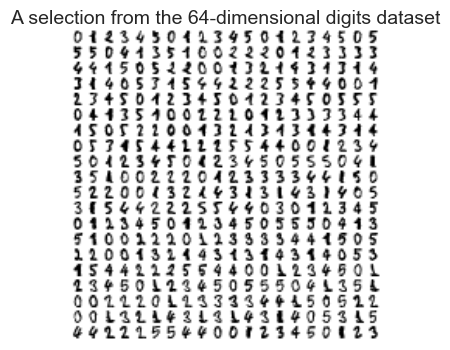

In [2]:
# Load the data from sklearn
digits = sklearn.datasets.load_digits(n_class=6)

# Store the data and targets
digit_images = digits.data
digit_classes = digits.target

# The data are rows of pixel values, and each pixel value is a feature (64 pixels in an 8x8 image).
n_samples, n_features = digit_images.shape

# Take a look at the data
n_img_per_row = 20
img = np.zeros((10 * n_img_per_row, 10 * n_img_per_row))
for i in range(n_img_per_row):
    ix = 10*i + 1
    for j in range(n_img_per_row):
        iy = 10*j + 1
        img[ix:ix + 8, iy:iy + 8] = digit_images[i * n_img_per_row + j].reshape((8,8))
        
plt.imshow(img, cmap=plt.cm.binary)
plt.xticks([])
plt.yticks([])
plt.title('A selection from the 64-dimensional digits dataset');

In the [tutorial](http://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html#sphx-glr-auto-examples-manifold-plot-lle-digits-py), they define a function to plot a picture of each number, rather than merely a point. This will be useful for determining the success of clustering.

In [3]:
def plot_embedding(embed, title=None, show_classes=True, show_examples=True):
    # Determine range of values of embedded points
    x_min, x_max = np.min(embed, 0), np.max(embed, 0)
    # Scale all points between 0 and 1
    scaled_embed = (embed - x_min) / (x_max - x_min)
    
    # Instantiate figure
    plt.figure()
    ax = plt.subplot(111)
    
    if show_classes:
        # Color each number differently (shows how we expect data to cluster)
        for i in range(scaled_embed.shape[0]):
            plt.plot(scaled_embed[i,0], scaled_embed[i,1], '.',
                     color = plt.cm.Set1(digit_classes[i]/10))
    else:
        plt.plot(scaled_embed[:,0], scaled_embed[:,1], '.k')
    
    if show_examples:
        if hasattr(offsetbox, 'AnnotationBbox'):
            # Only print thumbnail with matplotlib > 1.0; initialize shown_images array
            shown_images = np.array([[1, 1]])

            # Iterate through the number of digits we imported
            for i in range(digits.data.shape[0]):
                dist = np.sum((scaled_embed[i] - shown_images) **2, 1)
                # Don't put thumbnails too close together
                if np.min(dist) < 4e-3:
                    continue
                # Concatenate the  locations of the images to be plotted
                shown_images = np.r_[shown_images, [scaled_embed[i]]]
                # Define the grayscale image of the number
                imagebox = offsetbox.AnnotationBbox(
                    offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r),
                    scaled_embed[i])
                ax.add_artist(imagebox)
                
    # Remove x and y ticks
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

Now, we will use PCA (our linear approach) and t-SNE (our non-linear approach) to reduce this 64-dimensional dataset to 2 dimensions. (We will discuss the t-SNE syntax in more detail later on.) Keep in mind that each "dimension" is the grayscale value of each pixel in the image of the hand-drawn digit. We want to see if the structure of the data (i.e. what we know about which images are 0s, 1s, 2s, etc.) is visible in 2D.

In [4]:
# Time the PCA computation
t0 = time()
# Use singular value decomposition to find eigenvalues and eigenvectors
digit_pca = sklearn.decomposition.TruncatedSVD(n_components=2)
# Transform the data
embed_pca = digit_pca.fit_transform(digit_images)
# Store the time
t_pca = time() - t0
# Print time 
print('PCA took %.3fs.' % t_pca)

# Time the tSNE computation
t0 = time()
# Find the optimal low-dimensional representation with t-SNE
tsne = sklearn.manifold.TSNE(n_components=2, init='pca', random_state=0)
embed_tsne = tsne.fit_transform(digit_images)
# Store the time
t_tsne = time() - t0
# Print time
print('t-SNE took %.3fs.' % t_tsne)

PCA took 0.006s.
t-SNE took 10.121s.


Wow. We can already see that t-SNE takes almost 100 times longer. We can compare the results by plotting the resulting low-dimensional spaces (also called the embedding).

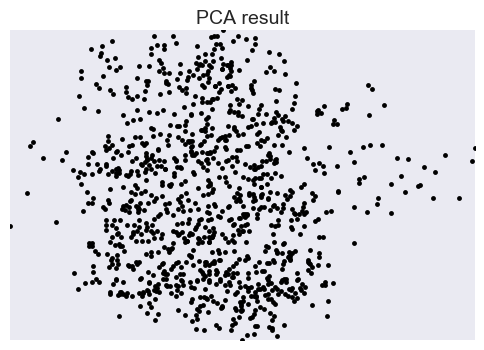

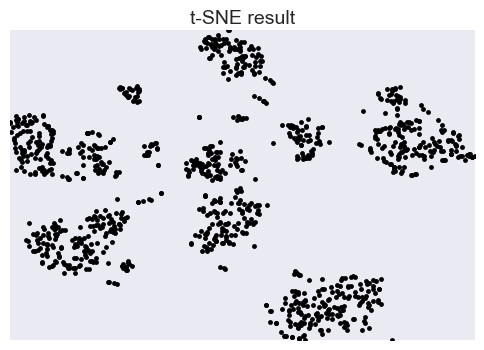

In [5]:
plot_embedding(embed_pca, "PCA result", show_classes=False, show_examples=False)
plot_embedding(embed_tsne, "t-SNE result", show_classes=False, show_examples=False)

Here, we see PCA fails to give us what we were after, which is how different or similar different hand-drawn digits are. Variance is preserved, but the spread of points is just that: a spread of points.

In contrast, t-SNE shows distinct groups. There are roughly 7-8 clusters, depending on how you count. This is intriguing as we know there are 6 hand-drawn digits, ranging from 0 to 5.

To get a better idea of what these maps are trying to communicate, let's color each point by the digit it represents, and overlay them with a few images of those hand-drawn digits.

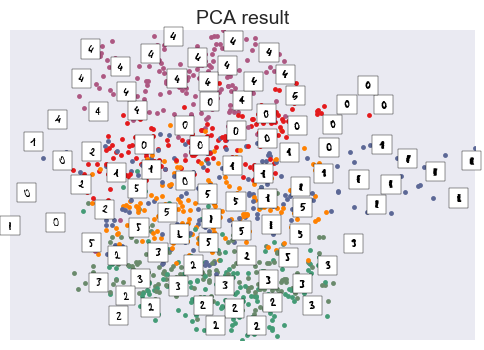

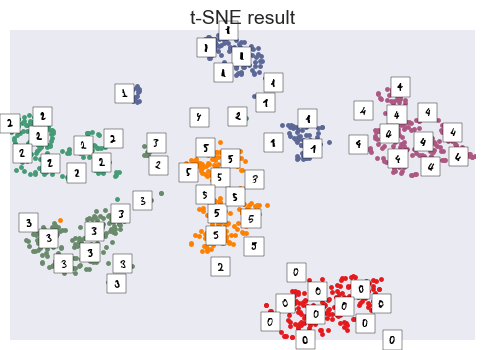

In [6]:
plot_embedding(embed_pca, "PCA result")
plot_embedding(embed_tsne, "t-SNE result")

We see that PCA did actually cluster the different numbers. But without separation between those clusters, we cannot learn much, particularly if we don't know the clusters beforehand!

t-SNE, on the other hand, separates the numbers into discrete clusters quite well, providing more information about the 'structure' of the data. It even distinguishes differences between numbers, and the distances between clusters can be meaningful. 1s separate into those drawn as vertical lines, those with 'hats', and those with a 'hat' and a horizontal bar at the bottom. 1s with hats, that start to resemble 4s, are close to the 4s. 1s with bars at the bottom, which start to resemble 2s, are close to the cluster of 2s.

So why does PCA fail?

### Long-range Euclidean distance, which PCA preserves, is not a good way to quantify (dis)similarity between datapoints for some datasets.

As stated previously, PCA preserves maximal variation in the low-dimensionality space, which might be useful if we want to reduce dimensionality but still visualize those large differences.

However, small differences, or strong similarity between points, is often more descriptive than those long-range distances, particularly for a dataset whose global structure is nonlinear. To cartoon this idea, think about a dataset shaped like a Swiss roll.

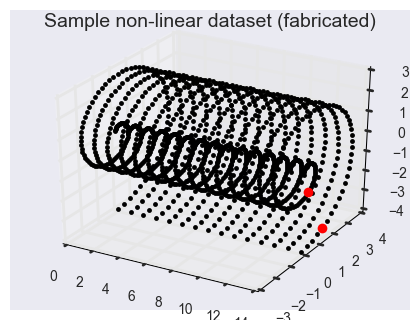

In [7]:
n_points = 100
th = np.linspace(0, 3*np.pi, n_points)
rad = np.linspace(0, 4, n_points)

x = rad * np.sin(th)
y = rad * np.cos(th)

fig = plt.figure(1, figsize=(4,3))
ax = mpl_toolkits.mplot3d.Axes3D(fig)
n_layers = 15;

# Plot our imaginary data
for i in range(n_layers):
    ax.plot(i*np.ones_like(x), x, y,'.k');

# Plot some interesting data points
i = 30;
j = 95;
ax.plot([n_layers-1, n_layers-1], [x[i], x[j]], [y[i], y[j]], 'or')

plt.title('Sample non-linear dataset (fabricated)');

By Euclidean distance, the two red points are fairly close to each other. But judging from the spiraling shape of the data-set, these points are actually much more dissimilar than their 3-D distance would suggest. A better measure of similarity would be to consider primarily nearest neighbors. Essentially, for a non-linear dataset, local linear distance is more meaningful than long-range linear distance.

### SNE: Preserve nearest neighbors in high-dimensional space by making them nearest neighbors in low-dimensional space.

[Nonlinear dimensionality reductions](https://en.wikipedia.org/wiki/Nonlinear_dimensionality_reduction) seek to preserve these short-range distances, and so, unlike PCA or other linear approaches, is not biased toward preserving long-range distances. Thus, they more robustly cluster similar and dissimilar data points. One such approach is called stochastic neighbor embedding (SNE).

#### Model similarity with conditional probability.

In SNE, the similarity between points $x_j$ and $x_i$ is the conditional probability of picking $x_j$ having selected $x_i$, where the probability of picking a point is Gaussian distributed about $x_i$. (It may help to think of this in analogy to the proposal distribution we used in the MCMC samplers, where you were more likely to pick 'close' steps than 'far' steps.) The probability of selecting a nearby point is fairly high, but the probability of selecting any point significantly farther than $\sigma_i$, whether it is moderately close or very far away, is vanishingly small. Formally, this is written as: 

\begin{align}
\\ p_{j|i} = \frac{\mathrm{exp}\left( -\| x_i - x_j \|^2 / 2 \sigma_i^2 \right)}{\sum_{k \neq i}\mathrm{exp}\left( -\| x_i - x_k \|^2 / 2 \sigma_i^2 \right)}
\end{align}

To preserve these nearest neighbors, we need a new distribution of points $\{y_1, ..., y_n\}$ that have similar conditional probabilities. Two points that were likely to be selected together in high-dimensional space ($x_i$ and $x_j$) must also be likely to be selected together in low-dimensional space ($y_i$ and $y_j$). We can also compute the conditional probabilities for points in low-dimensional space*:

\begin{align}
\\ q_{j|i} = \frac{\mathrm{exp}\left( -\| y_i - y_j \|^2 \right)}{\sum_{k \neq i}\mathrm{exp}\left( -\| y_i - y_k \|^2\right)}
\end{align}

#### Iterate to find an embedding $\{y_1, ..., y_n\}$ where the conditional probabilities of high and low dimensional space are most similar.

To determine the goodness of our embedding $\{y_1, ..., y_n\}$, we need a way to quantify how well $q_{j|i}$ captures $p_{j|i}$, or how close in the low-dimensional space are nearest neighbors from high-dimensional space. Such a measure already exists in information theory! 

The **[Kullback-Leibler divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence)** (KL divergence), developed in the 1950s, measures the difference between a true probability distribution (here, $p$) and an approximation (here, $q$). More specifically, it measures the information gained when you update a prior $q$ with full posterior probability distribution $p$. If $q$ approximates $p$ well, not much additional information is gained by considering $p$ rather than $q$. Therefore, SNE algorithms seek a low-dimensional distribution of points that minimizes the KL divergence. It is defined as:

\begin{align}
\\ C = \sum_i KL (P_i \| Q_i) = \sum_i \sum_j p_{j|i} \log \frac{p_{j|i}}{q_{j|i}}
\end{align}

We know $p_{j|i}$ is constant, because the high-dimensional map is fixed. $q_{j|i}$ can be high or low, depending on where points $y_i$ and $y_j$ are placed. We see there is a large penalty if $p_{j|i}$ is large, but $x_{j|i}$ is small. Conversely, if $p_{j|i}$ is small, any $x_{j|i}$ will have similarly small penalties. Stated differently, points close in high-dimensional space must stay close, and points that are distant in high-dimensional space can be placed just about anywhere.

To arrive at the final map, start with a random embedding $\{y_1, ..., y_n\}$. Then, use the gradient of the cost function (i.e. $C = \sum_i KL (P_i \| Q_i)$) to optimize the arrangement of points in low-dimensional space. The gradient has the form:

\begin{align}
\\ \frac{\partial C}{\partial y_i} = 2 \sum_j (p_{j|i} - q_{j|i} + p_{i|j} - q_{i|j}) (y_i - y_j)
\end{align}

In his [description](https://lvdmaaten.github.io/publications/papers/JMLR_2008.pdf), Laurens van der Maaten, the creator of t-SNE, considers this equation like a spring. All points $y_j$ exert some force on $y_i$ in the direction $(y_i - y_j)$ with force $(p_{j|i} - q_{j|i} + p_{i|j} - q_{i|j})$. We can think of $y_i$ being attracted and repulsed by adjacent points until it arrives at an optimal location.

#### Problems with SNE: computationally intensive and prone to "crowding."

Optimizing the cost function described above can require careful fine-tuning. This makes SNE time-consuming. However, there is a more signigicant problem.

Consider a sphere, where all points are equidistant from the center. We might represent the nearest neighbors as a circle in 2D. But where would you put all the points? In 3D, the points are spread over $4 \pi r^2$, but in 2D must spread over $2 \pi r$. There is much less 'volume' in low-dimensional space, which results in crowding. This problem grows with dimensions, as the volume to spread points of a 10 dimensional cube goes like $r^9$.

If there is not enough room for the points in low-dimensional space, they will tend to spread. However, SNE strongly penalizes pushing points farther apart than they need to be. The summed attractive force of its nearby neighbors will "crush" all the points to the origin, which is not a useful visualization.**

### t-SNE: Compensate for mistmatched dimensionalities with mismatched tails.

We've seen that representing high-dimensional data in low-dimensional space will push the embedded points $\{y_1, ..., y_n\}$ farther apart, which is heavily penalized by the light-tailed Gaussian for $q_{j|i}$. However, we could define a different probability distribution for low-dimensional space that considers these farther distances as still relatively probable! Van der Maaten chose the heavy-tailed Student t-distribution with 1 degree of freedom (which is the same as a Cauchy distribution). Thus, the method was named **t-distributed Stochastic Neighbor Embedding**. 

Now, $q_{j|i}$ has the form:

\begin{align}
\\ q_{j|i} = \frac{\left(1 +\| y_i - y_j \|^2 \right)^{-1}}{\sum_{k \neq i} \left(1 +\| y_i - y_k \|^2 \right)^{-1}}
\end{align}

This allows an embedded point to be moderately far from its neighbors without generating an attractive force between it and all the moderately distant dissimilar points. The resulting cost function ($C = KD(P\|Q)$) still has the desired property of pushing apart embedded points that are moderate to far apart in high-dimensional space, as well as pushing together points which are close in high-dimensional space. The magnitudes of these forces are also much more reasonable than in SNE (e.g. do not increase as embedded points get farther apart from each other; see [Figure 1](https://lvdmaaten.github.io/publications/papers/JMLR_2008.pdf) in the original t-SNE paper).

**Aside about speed:** Using a Cauchy distribution is faster than a Gaussian, as exponentials require slightly longer to compute. However, t-SNE is also faster because it uses a symmetric (with respect to $i$ and $j$) form of the Kullback-Leibler distribution that yields a simplified form of the gradient.

### Applying t-SNE to a biological dataset: SNP data from different countries

We used PCA to replicate Lior Pachter's [satirical experiment](https://liorpachter.wordpress.com/2014/12/02/the-perfect-human-is-puerto-rican/) using 2D visualizations of SNP data to find the most nearly perfect human. The previous [PCA tutorial](http://bebi103.caltech.edu/2016/tutorials/aux4_pca.html) discussed the logical difficulties of assigning human fitness to arbitrarily "good" SNPs, as well as the assumption that the "best" human would be one that was closest to the perfect human in a 2D space. However, PCA was an interesting way to look at the structure of the SNP data, and see how it failed to describe such an intrinsically high-dimensional data-set. We required a third principal component to visualize how the 'perfect human' actually had very little in common with any of the other humans represented in the dataset.

Perhaps t-SNE can generate a more successful 2D rendering that shows how dissimilar the 'perfect' human is from other empirically-observed humans?

In [8]:
# Read the SNP table
df_snp = pd.read_csv('../data/pachter/geno_table.txt', delimiter='\t',
                     index_col='snp_id').transpose()
# Convert data to floats
df_snp = df_snp.astype(np.float)

# Take a look at data
df_snp.head()

snp_id,rs307377,rs7366653,rs41307846,rs3753242,rs35082957,rs34154371,rs35426403,rs1143016,rs3890745,rs17472401,...,rs6007897,rs9615362,rs9627183,rs28372448,rs121913039,rs121913037,rs5770917,rs6151429,rs743616,rs2071421
perfect,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
HG00096,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
HG00097,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
HG00099,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
HG00100,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


We will add data about the individuals, such as where they are from, to our `DataFrame`, and call them auxiliary columns.

In [9]:
# Read the description of each individual
fname = '../data/pachter/integrated_call_samples_v3.20130502.ALL.panel'
df_info = pd.read_csv(fname, delimiter='\t', 
                      index_col=0).dropna(axis=1, how='all')

# Add to the SNP dataframe the information about gender and super_pop
aux_cols = ['pop', 'super_pop', 'gender']
df_snp[aux_cols] = df_info

# Change the super_pop column for the perfect human being
df_snp.loc['perfect', ['pop', 'super_pop']] = ['Perfect Human']*2

# Take a look at auxiliary columns
df_snp[aux_cols].head()

snp_id,pop,super_pop,gender
perfect,Perfect Human,Perfect Human,NaN
HG00096,GBR,EUR,male
HG00097,GBR,EUR,female
HG00099,GBR,EUR,female
HG00100,GBR,EUR,female


Now we can perform t-SNE.

In [10]:
# Time the tSNE computation
t0 = time()

# Find the optimal low-dimensional representation with t-SNE
tsne_snp = sklearn.manifold.TSNE(n_components=2, init='pca', random_state=0)
embed_snp = tsne.fit_transform(df_snp.drop(aux_cols, axis=1))

# Store the time
t_tsne = time() - t0
# Print time
print('t-SNE took %.2fs.' % t_tsne)

t-SNE took 22.90s.


Store results in a `DataFrame` and plot.

In [11]:
# Convert to DataFrame
df_tsne_snp = pd.DataFrame(embed_snp, 
                           columns=['tsne1','tsne2'],
                           index=df_snp.index)
# Add the meta-data
df_tsne_snp[aux_cols] = df_snp[aux_cols]
df_tsne_snp.head()

,tsne1,tsne2,pop,super_pop,gender
perfect,12.399028,-6.666427,Perfect Human,Perfect Human,NaN
HG00096,-4.530343,-27.249118,GBR,EUR,male
HG00097,-13.585389,-27.875435,GBR,EUR,female
HG00099,-4.572882,-27.240533,GBR,EUR,female
HG00100,-7.701902,-25.024892,GBR,EUR,female


In [12]:
# What pops up on hover?
tooltips = [('gender', '@gender'),
            ('pop', '@pop'),
            ('ID', '@index')]

# Make the hover tool
hover = bokeh.models.HoverTool(tooltips=tooltips)

# Create figure
p = bokeh.plotting.figure(plot_width=650, plot_height=450, x_axis_label='t-SNE axis 1',
                          y_axis_label='t-SNE axis 2')

# Add the hover tool
p.add_tools(hover)

# Define colors in a dictionary to access them with
# the key from the pandas groupby funciton.
keys = df_tsne_snp.super_pop.dropna().unique()
color_dict = {k: bebi103.rgb_frac_to_hex(sns.color_palette()[i]) 
                      for i, k in enumerate(sorted(keys))}

for key, group in df_tsne_snp.groupby('super_pop'):
    # Specify data source
    source = bokeh.models.ColumnDataSource(group)
    
    # Populate glyphs
    if key == 'Perfect Human':
        p.diamond_cross(x='tsne1', y='tsne2', size=20, source=source, 
                        color='black', fill_color=None, line_width=2,
                        legend=key)
    else:
        p.circle(x='tsne1', y='tsne2', size=7, alpha=0.5, source=source,
                 color=color_dict[key], legend=key)

p.legend.background_fill_alpha = 0.25
p.legend.location = 'bottom_right'
# Blanched almonds are the best kind of almonds
p.legend.background_fill_color = 'blanchedalmond'
bokeh.io.show(p)

Here we see t-SNE performs slightly better than PCA. Already, our 2D map shows that the perfect human does not fit in any clusters with the other datapoints, which matches the PCA result that the perfect human is not quite human. (Why we didn't request samples from Xavier's School for Gifted Youngsters is beyond me.) However, in case we are interested, the perfect human now appears to be a [woman of African descent from the Southwestern United States](https://catalog.coriell.org/0/Sections/Search/Sample_Detail.aspx?Ref=NA19923&Product=DNA). Apparently, [superpopulation has little to do with geography](http://www.internationalgenome.org/category/population/).

### Applying t-SNE to biological datasets: RNA-Seq of different tissue types

We know that different tissues have different mRNA profiles. However, I have little intuition about how different I expect various tissues to be, and whether certain tissues might be quite similar at the transcriptional level. We could use t-SNE to visualize this structure, where we cluster the RNA-Seq profiles for different tissues, and color by tissue.

This was done in a [paper](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0149853) by Erdogan Taskesen and Marcel J. T. Reinders, who are from the same Netherlands university where the creator of t-SNE previously worked. The [data and analysis](https://data.4tu.nl/repository/uuid:ec5bfa66-5531-482a-904f-b693aa999e8b) are freely available for download if you register at their data-collection site, but you can download the files I got [here](../data/taskesen.zip).

In [13]:
# Read in FPKM values
df_rna = pd.read_csv('../data/taskesen/GTExdata.csv',header=None)
df_rna.head()

,0,1,2,3,4,5,6,7,8,9,...,16132,16133,16134,16135,16136,16137,16138,16139,16140,16141
0,-0.814430,-0.172800,-0.135660,4.0360,3.47420,0.017055,0.76495,3.0281,0.56595,1.9045,...,-0.88508,-2.22280,-3.038500,-2.85840,-3.472400,-2.537400,-2.970500,-1.83970,-2.10440,-1.988100
1,-1.219500,-0.139670,-0.217330,-1.4361,-0.86158,0.403280,-0.91309,6.9136,4.38540,6.1544,...,2.01310,1.25060,0.333560,0.37651,-0.086984,0.221580,1.205700,0.81913,0.20093,1.371100
2,-0.010044,-0.042155,0.111440,-1.0768,-0.72246,0.651900,-0.79763,5.6678,2.94680,4.6342,...,-1.07800,-0.52936,-0.989140,-3.10870,-3.262500,-1.159200,0.091823,-1.14740,-1.59540,-0.092996
3,-1.336400,-0.088622,-0.126460,-1.7866,-0.99562,0.009797,-1.05550,6.5985,4.22730,6.0226,...,0.67228,0.98691,0.142270,0.34028,-0.129170,0.064783,1.279200,1.05850,0.63342,1.581000
4,-1.055100,-0.065230,-0.087368,-1.4559,-0.69961,0.205960,-0.83905,6.1986,4.05600,5.7843,...,0.48401,0.63014,0.061371,-0.82861,-1.537200,-0.121850,0.735520,0.32366,-0.54558,0.789580


In [14]:
# Read in labels for samples.
df_labels = pd.read_csv('../data/taskesen/SampleLabels.csv')
# Rename columns for convenience
aux_cols = ['sample_id','tissue_type_specific','tissue_type']
df_labels.columns = aux_cols
df_labels.head()

,sample_id,tissue_type_specific,tissue_type
0,GTEX-N7MS-0007-SM-2D7W1,Whole Blood,Blood
1,GTEX-N7MS-0011-R10A-SM-2HMJK,Brain - Frontal Cortex (BA9),Brain
2,GTEX-N7MS-0011-R11A-SM-2HMJS,Brain - Cerebellar Hemisphere,Brain
3,GTEX-N7MS-0011-R1a-SM-2HMJG,Brain - Hippocampus,Brain
4,GTEX-N7MS-0011-R2a-SM-2HML6,Brain - Substantia nigra,Brain


In [15]:
# Time the tSNE computation
t0 = time()

# Find the optimal low-dimensional representation with t-SNE
tsne_rna = sklearn.manifold.TSNE(n_components=2, init='pca', random_state=0)
embed_rna = tsne.fit_transform(df_rna)

# Store the time
t_tsne = time() - t0
# Print time
print('t-SNE took %.2fs.' % t_tsne)

t-SNE took 121.22s.


Next, we plot the results, and color by tissue. We hope to see how well we grouped the various tissues, and perhaps gauge the relative similarity between various tissues.

In [16]:
# Convert to DataFrame
df_tsne_rna = pd.DataFrame(embed_rna, 
                           columns=['tsne1','tsne2'],
                           index=df_rna.index)

# Add meta-data
df_tsne_rna[aux_cols] = df_labels[aux_cols]

# What pops up on hover?
tooltips = [('tissue', '@tissue_type'),
            ('specific', '@tissue_type_specific')]

# Make the hover tool
hover = bokeh.models.HoverTool(tooltips=tooltips)

# Create figure
p = bokeh.plotting.figure(plot_width=900, plot_height=650, x_axis_label='t-SNE axis 1',
                          y_axis_label='t-SNE axis 2')

# Add the hover tool
p.add_tools(hover)

# Define colors in a dictionary to access them with
# the key from the pandas groupby funciton.
keys = df_tsne_rna.tissue_type.dropna().unique()
color_dict = {k: bebi103.rgb_frac_to_hex(sns.color_palette('RdBu',n_colors=len(keys))[i]) 
                      for i, k in enumerate(sorted(keys))}

for key, group in df_tsne_rna.groupby('tissue_type'):
    # Specify data source
    source = bokeh.models.ColumnDataSource(group)
    
    # Populate glyphs
    p.circle(x='tsne1', y='tsne2', size=7, alpha=0.5, source=source,
             color=color_dict[key], legend=key)
# Uncomment to see legend (a bit too large for plot)
p.legend.background_fill_alpha = 0.25
p.legend.location = 'bottom_right'
p.legend.label_text_font_size = '12pt'

# Blanched almonds are the best kind of almonds
p.legend.background_fill_color = 'blanchedalmond'
bokeh.io.show(p)

Intriguing! There is good separation of some tissues, where brain and blood separate far from others. *Post mortem* blood clusters far away from other blood samples. Also, if we zoom in on some clusters, like the brain cluster, the more specific tissue types also form clusters. The closesness of clusters might also give us intuition about the similarity of tissues. For example, the cardiac tisue is somewhat similar to the skeletal muscle.

However, now we start to see the limitations of this approach. First, we didn't learn much. Given a data-set $\{x_i\}$ with 16,142 dimensions, we specified some learning parameters (default kwargs in `sklearn`, see below for more details) and generated $\{y_j\}$. We don't know which dimensions (i.e. which gene's mRNA levels) are useful for specifying these clusters, and given a new mRNA profile, we wouldn't know where it fits on this map. 

Also, this result doesn't quite match what was reported in the paper. Their t-SNE plot is shown below.

![Figure 1 of Taskesen and Reinders 2010](aux8_tsne_fig1.png)

When we consult their [Methods](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0149853#sec002) section, we see the authors ran t-SNE 1000 times to find the map with the lowest KL divergence. What's going on?

### Weaknesses of t-SNE

* **KL divergence is not convex, so each t-SNE run yields a different result.** Since the cost-function we are optimizing is not convex, a solution is not guaranteed to be a global minimum. Thus, you might have to run t-SNE many times before finding a satisfactory result.

Van der Maaten is careful to note that optimizing a non-convex function will always be preferred (1) if the result is better than the global optimum of another cost function and (2) if it is the most computationally feasible. 

* **t-SNE is a non-parametric.** Because this algorithm only returns the optimal embedded map, we gain no new information about how to classify the data, which dimensions of the dataset are important, or how we might classify a new point not already shown in the map. The main usefulness of this technique is to visualize the data structure.

* **t-SNE cannot visualize data with high intrinsic dimensionality.** By using local Euclidean distance, this approach assumes data are locally linear. It also assumes that the dataset is only _superficially_ high-dimensional. Van der Maaten points out: 

> "[T]he reader should note that it is by definition impossible to fully represent the structure of intrinsically-high dimensional data in two or three dimensions."

* **t-SNE behaves unpredictably if we reduce dimensionality to $d > 3$.** In multi-dimensional Student-t distributions, the majority of the probability distribution is in the tails, which may allow clusters to spread farther apart than would be a useful representation. Van der Maaten recommends increasing the degrees of freedom of the Student-t, which lightens the tails, but does not outline a specific approach.

### Summary

* Visualizing a high-dimensional biological dataset in 2D is useful for understanding its intrinsic structure.
* Linear dimensionality reduction cannot cluster data with non-linear global structure.
* This is because long-range Euclidean distance, which PCA preserves, is not a good way to quantify (dis)similarity between datapoints for some datasets. Locally linear distance is more meaningful.
* Stochastic neighbor embedding (SNE) preserves nearest neighbors in high-dimensional space by making them nearest neighbors in low-dimensional space.
* t-distributed SNE (t-SNE) compensates for mismatched dimensionalities with mismatched tails (i.e. Guassian in high-dimensional space, Student-t in low-dimensional space).
* t-SNE has a few weaknesses to be aware of: each run can yield different results, the results are non-parameteric, and local linear distances cannot always capture intrinsic dimensionality.


### References
Informal introduction to t-SNE, by creator. [Google TechTalk](https://www.youtube.com/watch?v=RJVL80Gg3lA).

Formal introduction to t-SNE: L.J.P. van der Maaten and G.E. Hinton. Visualizing High-Dimensional Data Using t-SNE. _Journal of Machine Learning Research_ 9(Nov):2579-2605, 2008.

Using the Barnes-Hut approximation: L.J.P. van der Maaten. Accelerating t-SNE using Tree-Based Algorithms. _Journal of Machine Learning Research_ 15(Oct):3221-3245, 2014.


**Footnotes**  
\*We've taken an arbitrary constant for $\sigma$, which is $\frac{1}{\sqrt{2}}$. Any other choise only results in a rescaled version of the final map.  
\**UNI-SNE tries to fix this problem by introducing a 'background repulsion' that keeps points from being pulled to the origin. However, clusters that separate early in the optimization are thus more likely to stay separate, which may create artificial structure.

### More fun t-SNE notes

* **To fully specify the optimization algorithm:**  

Guesses for the embedded points $\{y_1, ..., y_n\}$ are updated by the following function:

\begin{align}
\\ \mathscr{Y}^{(t)} = \mathscr{Y}^{(t-1)} + \eta \frac{\delta C}{\delta \mathscr{Y}} + \alpha (t) \left[ \mathscr{Y}^{(t-1)} - \mathscr{Y}^{(t-2)} \right]
\end{align}

where $\mathscr{Y}^{(t)}$ is the map of embedded points at iteration $t$, $\eta$ is the learning rate, $C$ is the cost function, and $\alpha(t)$ is the momentum. The `sklearn` implemention of t-SNE has good default kwargs for these values, but it's perhaps worth noting that these must be (somewhat arbitrarily) specified to get reasonable results.

You can also specify $\sigma_i$ for each point. This is chosen such that the "perplexity," a rough measure of the number of nearest neighbors, is constant for all datapoints. This corrects for the fact that some points $x_i$ will be in sparser regions than other points. If $\sigma_i$ is too small, all other points $x_j$ will be so far from $x_i$ that it has no effect on the resulting low-dimensional map. Thus, choosing a good value for $\sigma_i$ allows you to weight all points relatively equally. `sklearn` will do this for us automatically.

* **For large datasets:** 

Computing pairwise distances scales like $O(N^2)$, and can become computationally infeasible for real-world datasets with thousands of data points. It would be easier to instead cluster a subset of the data; however, we lose information about the local density provided by those missing points. Instead, you can represent a clusters of points by their center of mass, multiplied by the number of points in the cluster. Thus, you fully approximate the effect of that dense cluster. These clusters of points are determined by the [Barnes-Hut approximation](https://en.wikipedia.org/wiki/Barnes%E2%80%93Hut_simulation), which has criteria for subdividing the high-dimensional space.

Also, for all the implementations here, `sklearn` first runs PCA on the data to reduce the dimensionality. As an analytical approach, this is much faster, and reduces the size of computations for t-SNE.

* **For optimized iterations:** 

Arbitrarily keeping the embedded points close ("early compression") early in the optimization allows freer movement of clusters past each other. By constrast, multiplying $p_{j|i}$ by 4, when $q_{j|i}$ is bounded between 0 and 1, increases the cost of any embedding that does not move the embedded points very close together. By forcing tighter clusters, this approach ("early exaggeration") causes the low-dimensional maps to become very separated. 